In [1]:
import pandas as pd

# Load the dataset
file_path = '/Users/rohithjoginapally/Desktop/ALY6040_DataMiningApplications/Prop_DB_2020_2022.xlsx'
data = pd.read_excel(file_path)

In [2]:
# Data Cleaning Steps
# 1. Handle Missing Values
data.dropna(subset=['Latitude', 'Longitude'], inplace=True)
categorical_columns_with_na = ['Interior_Flooring', 'Systems_HeatType']
data[categorical_columns_with_na] = data[categorical_columns_with_na].fillna('Unknown')
numerical_columns_with_na = ['Interior_NumUnits', 'Interior_Kitchens', 'Exterior_FloorLocation']
data[numerical_columns_with_na] = data[numerical_columns_with_na].fillna(0)


In [3]:
# 2. Correct Data Types
data['GISID'] = pd.to_datetime(data['GISID'], errors='coerce')
data['SaleDate'] = pd.to_datetime(data['SaleDate'], errors='coerce')

In [4]:
# 3. Remove Duplicates
data.drop_duplicates(inplace=True)


In [5]:
# Create 'Years_Since_Sale'
data['Years_Since_Sale'] = 2023 - data['SaleDate'].dt.year

# Create 'Building_Age'
data['Building_Age'] = 2023 - data['Condition_YearBuilt']

# Drop original 'SaleDate' and 'Condition_YearBuilt'
data.drop(['SaleDate', 'Condition_YearBuilt'], axis=1, inplace=True)

In [6]:
# Display the updated dataframe
data.head()

,PID,GISID,Latitude,Longitude,PropertyClass,LandArea,YearOfAssessment,TaxDistrict,ResidentialExemption,BuildingValue,...,Interior_Fireplaces,Interior_Flooring,Interior_LaundryInUnit,Systems_HeatType,Condition_OverallCondition,Parking_Open,Parking_Covered,Parking_Garage,Years_Since_Sale,Building_Age
0,657,2023-01-17,42.3683,-71.0821,CONDOMINIUM,0,2021,R1,False,323300,...,0,Unknown,False,Unknown,Fair,0,0,0,29,108
1,658,2023-01-17,42.3683,-71.0821,CONDOMINIUM,0,2021,R1,False,353000,...,0,Unknown,False,Unknown,Fair,0,0,0,29,108
2,659,2023-01-17,42.3683,-71.0821,CONDOMINIUM,0,2021,R1,False,353000,...,0,Unknown,False,Unknown,Fair,0,0,0,29,108
3,660,2023-01-17,42.3683,-71.0821,CONDOMINIUM,0,2021,R1,False,323300,...,0,Unknown,False,Unknown,Fair,0,0,0,29,108
4,661,2023-01-17,42.3683,-71.0821,CONDOMINIUM,0,2021,R1,False,353000,...,0,Unknown,False,Unknown,Fair,0,0,0,29,108


In [7]:
data.shape

(37384, 34)

In [8]:
import numpy as np

# Function to detect outliers based on IQR
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[c], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[c], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature c
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index

        # Append the found outlier indices for c to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than 2 outliers
    outlier_indices = list(set(outlier_indices))
    return outlier_indices

# Detecting outliers in the numerical features
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
outlier_indices = detect_outliers(data, numerical_features)

# Removing the outliers
cleaned_data_no_outliers = data.drop(outlier_indices)

# Shape of the data after removing outliers
cleaned_data_no_outliers.shape


(18265, 34)

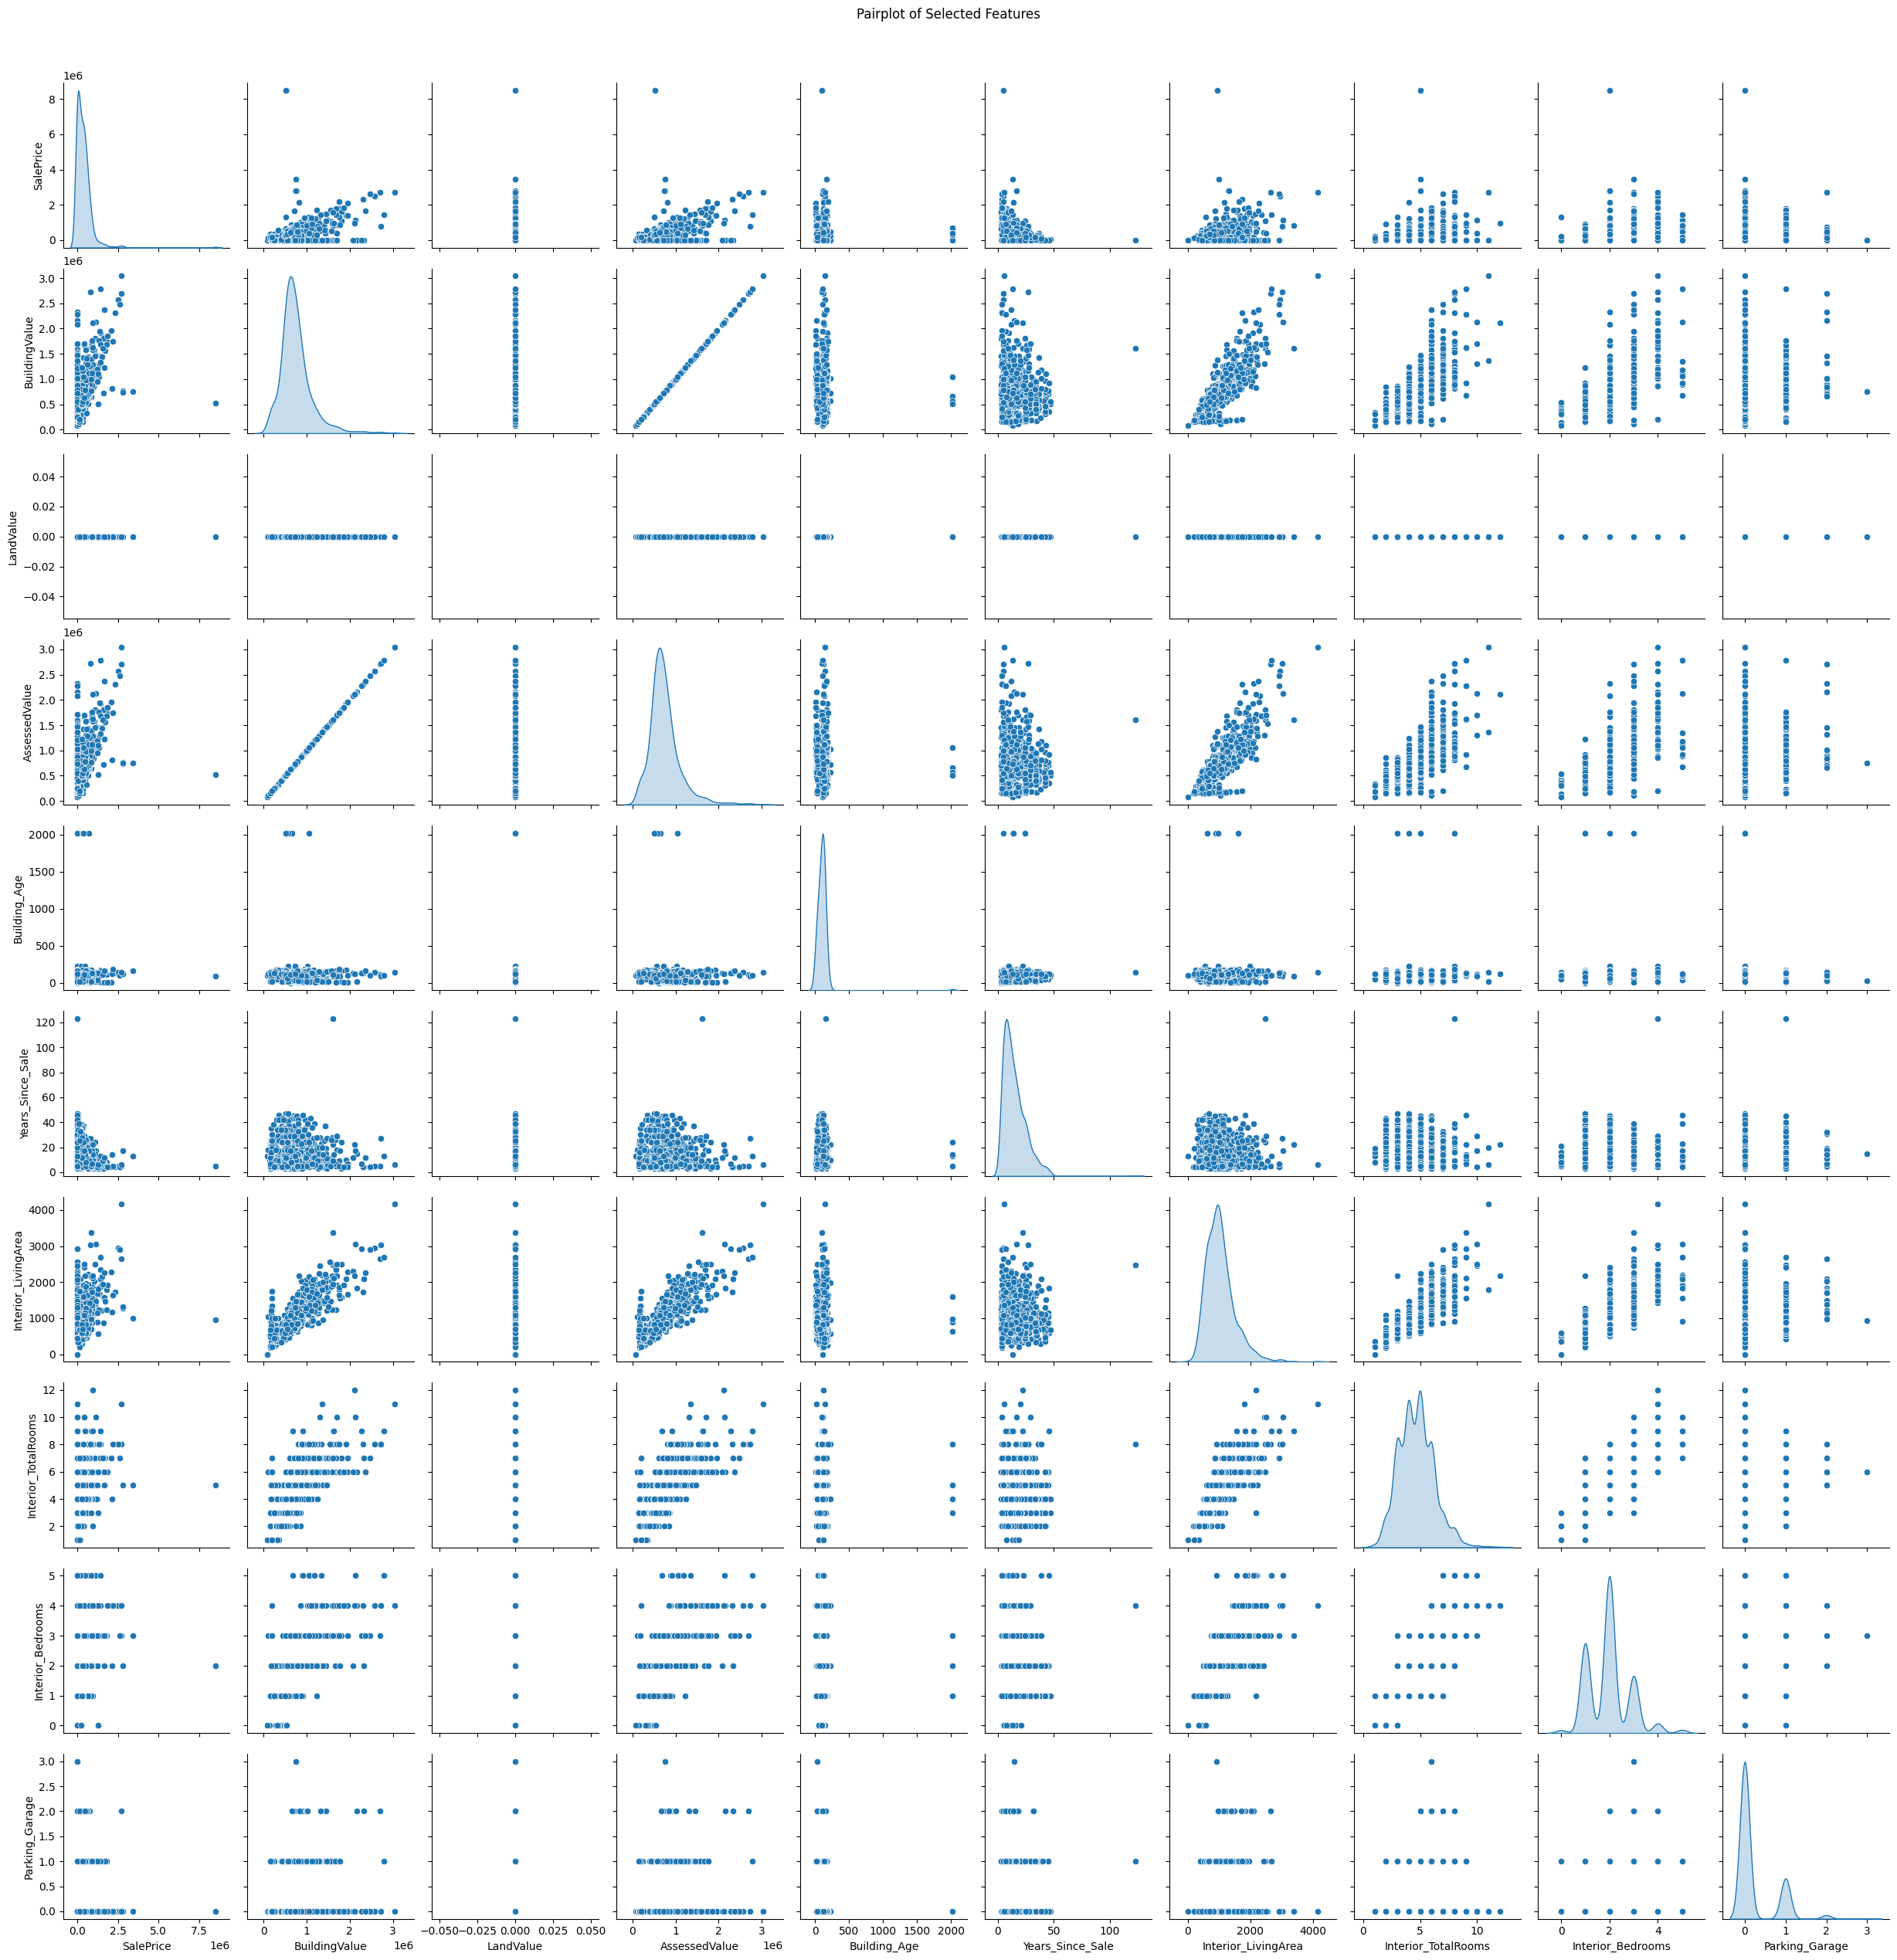

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# Selecting a subset of columns for EDA
eda_columns = ['SalePrice', 'BuildingValue', 'LandValue', 'AssessedValue', 
               'Building_Age', 'Years_Since_Sale', 'Interior_LivingArea', 
               'Interior_TotalRooms', 'Interior_Bedrooms', 'Parking_Garage']

# Creating a smaller dataframe for EDA
eda_data = data[eda_columns]

# Pairplot for selected numerical features
sns.pairplot(eda_data.sample(1000), diag_kind='kde')  # Sampling to make it computationally efficient
plt.suptitle("Pairplot of Selected Features", y=1.02)  # Adjusting title position
plt.show()


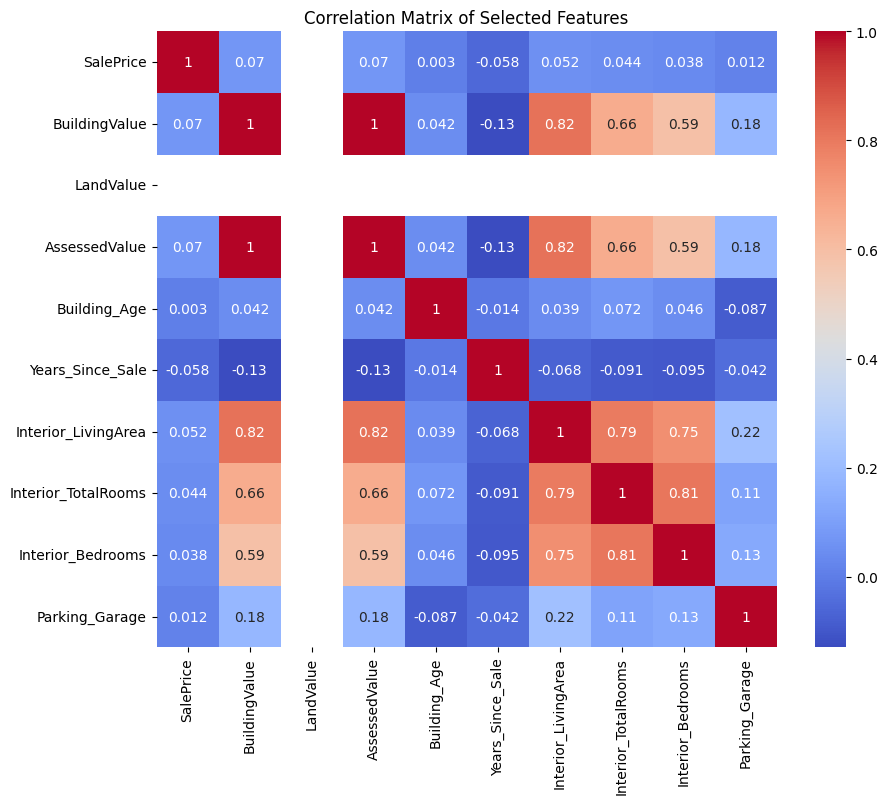

In [10]:
# Correlation matrix
correlation_matrix = eda_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
selected_features = ['BuildingValue', 'LandValue', 'AssessedValue', 
                     'Building_Age', 'Years_Since_Sale', 'Interior_LivingArea', 
                     'Interior_TotalRooms', 'Interior_Bedrooms', 'Parking_Garage',
                     'PropertyClass', 'TaxDistrict']

# Target variable
target = 'SalePrice'

# Splitting the dataset into features (X) and target (y)
X = data[selected_features]
y = data[target]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifying categorical columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Creating a Column Transformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in selected_features if col not in categorical_features]),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Creating a pipeline with preprocessing and the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model
model.fit(X_train, y_train)

# Predicting on test data
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE - ', mse)
print('r2 - ',r2)



MSE -  209357209520.07343
r2 -  0.23412723855548379


The R² score of 0.235 indicates that approximately 23.5% of the variability in the sale prices is explained by the model. The relatively high MSE and the low R² suggest that the model's predictive performance is modest. This could be due to several factors, such as the nature of the data, the selection of features, or the model's simplicity.



In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature Selection
selected_features = ['BuildingValue', 'LandValue', 'AssessedValue', 
                     'Building_Age', 'Years_Since_Sale', 'Interior_LivingArea', 
                     'Interior_TotalRooms', 'Interior_Bedrooms', 'Parking_Garage']
target = 'SalePrice'

# Preparing the data
X = cleaned_data_no_outliers[selected_features]
y = cleaned_data_no_outliers[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifying categorical columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Preprocessing: StandardScaler for numerical features, OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in selected_features if col not in categorical_features]),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Random Forest Regressor model
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

# Training the model
rf_model.fit(X_train, y_train)

# Predicting on test data
y_pred = rf_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 23225432827.061226
R² Score: 0.6470895891183139


MSE: The mean squared error has decreased significantly to approximately 21.78 billion, compared to the earlier linear regression model. This indicates a substantial improvement in the accuracy of the model's predictions.
R² Score: The R² score has improved markedly to 0.669, which means that about 66.9% of the variability in 'SalePrice' is now explained by the model. This is a considerable improvement over the linear regression model and suggests that the Random Forest Regressor is capturing the relationships in the data more effectively.

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest hyperparameters grid for Random Search
param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [10, 20, 30, 40, 50, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Creating the Random Search with the Random Forest model
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                      n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fitting the Random Search model
rf_random_search.fit(X_train, y_train)

# Best parameters found by Random Search
best_params = rf_random_search.best_params_
best_score = rf_random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  11.7s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  11.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  11.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  12.6s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  12.5s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=200; total time=  12.7s
[CV] END regressor__max_depth=40, regressor__min_sa

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Random Forest Regressor model with optimized parameters
optimized_rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=30,
        random_state=42))
])

# Training the optimized model
optimized_rf_model.fit(X_train, y_train)

# Predicting on test data
y_pred_optimized = optimized_rf_model.predict(X_test)

# Evaluating the optimized model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized RF Model - Mean Squared Error: {mse_optimized}")
print(f"Optimized RF Model - R² Score: {r2_optimized}")


Optimized RF Model - Mean Squared Error: 21426414594.48409
Optimized RF Model - R² Score: 0.6744256679922755


In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost Regressor model
xgboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective ='reg:squarederror', random_state=42))
])

# Training the XGBoost model
xgboost_model.fit(X_train, y_train)

# Predicting on test data
y_pred_xgb = xgboost_model.predict(X_test)

# Evaluating the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model - Mean Squared Error: {mse_xgb}")
print(f"XGBoost Model - R² Score: {r2_xgb}")

XGBoost Model - Mean Squared Error: 28949166415.08095
XGBoost Model - R² Score: 0.5601174673341389


In [16]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Defining the hyperparameter grid
param_grid = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9]
}

# XGBoost Regressor pipeline
xgboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Randomized Search with Cross-Validation
xgb_random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_grid, 
                                       n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fitting the Randomized Search model
xgb_random_search.fit(X_train, y_train)

# Best parameters
best_params_xgb = xgb_random_search.best_params_
best_score_xgb = xgb_random_search.best_score_

print("Best Parameters for XGBoost:", best_params_xgb)
print("Best Score:", best_score_xgb)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.7; total time=   0.3s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.7; total time=   0.4s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.7; total time=   0.4s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100, regressor__subsample=0.7; total time=   0.5s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100, regressor__subsample=0.7; total time=   0.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__m

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Setting the best parameters in the XGBoost model
xgboost_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        subsample=0.8,
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42))
])

# Retraining the model with the optimized hyperparameters
xgboost_optimized.fit(X_train, y_train)

# Predicting on test data with the optimized model
y_pred_xgb_optimized = xgboost_optimized.predict(X_test)

# Evaluating the optimized model
mse_xgb_optimized = mean_squared_error(y_test, y_pred_xgb_optimized)
r2_xgb_optimized = r2_score(y_test, y_pred_xgb_optimized)

print(f"Optimized XGBoost Model - Mean Squared Error: {mse_xgb_optimized}")
print(f"Optimized XGBoost Model - R² Score: {r2_xgb_optimized}")


Optimized XGBoost Model - Mean Squared Error: 31980323956.19121
Optimized XGBoost Model - R² Score: 0.5140590338381678


The R² score of 0.514 indicates that the model explains approximately 51.4% of the variability in the 'SalePrice', which is an improvement from the initial XGBoost model but still lower than the optimized Random Forest model (R² of 0.674).
The MSE is higher compared to the optimized Random Forest model, suggesting the predictions are, on average, further from the actual values.


In [21]:
import joblib

# Assuming 'rf_model' is your optimized Random Forest pipeline
joblib.dump(rf_model, 'compressed_random_forest_model.joblib', compress = 2)


['compressed_random_forest_model.joblib']